# Manual annotations

We (TR) created manual annotations for 9 patients from the Kaggle dataset (randomly selected from the p15 set). For each patient diastole, systole and four additional phases were labeled in all slices. This way 552 ground truth annotations were generated. Additionally for patient 98, all other phases were annotated as well. In order not to distort analyses by disproportionat images from a single patient. These additional masks were excluded for most analyses (detailed comparison, see bottom).

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
metadata <- read_tsv("../../analysis/kaggle/patient_metadata.tsv")


── Column specification ────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  PatientsAgeNum = col_character(),
  PatientsAgeUnit = col_character(),
  PatientsSex = col_character(),
  pid = col_character(),
  used = col_logical(),
  set = col_character(),
  PhaseEncodingDirection = col_character(),
  ModelName = col_character(),
  PixelSpacing = col_character(),
  ScanningSequence = col_character(),
  SequenceName = col_character(),
  SequenceVariant = col_character(),
  SoftwareVersion = col_character(),
  inconsistentMetadata = col_logical()
)
ℹ Use `spec()` for the full column specifications.




In [3]:
get_own_predictions <- function(file, size=256){
    own_pred <- read_tsv(file)
    # get Id, frame and slice from filename
    own_pred <- own_pred %>%
        separate(file,into=c("Id","frame","slice"),sep="-") %>%
        mutate(
            frame=str_replace(frame,"frame",""),
            frame=as.numeric(frame),
            slice=str_replace(slice,"slice",""),
            slice=str_replace(slice,".png",""),
            slice=as.numeric(slice)
        ) %>%
        filter(Id != 98 | frame %in% seq(0,20,4)) # subset patient 98 to 6 slices
    # sum voxels in all slices per frame
    own_pred <- own_pred %>% group_by(Id, frame) %>% summarise(lv_voxels=sum(lv))
    # get systolic (least) and diastolic (most) frames
    own_pred_dia <- own_pred %>%
        group_by(Id) %>%
        top_n(1, lv_voxels) %>%
        top_n(1, frame) # in case of ties keep only highest frame
    own_pred_sys <- own_pred %>%
        group_by(Id) %>%
        top_n(1, -lv_voxels) %>%
        top_n(1, -frame) # in case of ties keep only lowest frame
    own_pred_both <- left_join(
        select(own_pred_dia,Id,dia_voxels=lv_voxels),
        select(own_pred_sys,Id,sys_voxels=lv_voxels)
    ) %>% mutate(pid=str_replace(Id,"_rot90",""))
    patient_dimensions <- select(metadata, pid, X, Y, pixelSpacingX, pixelSpacingY, sliceSpacing) %>%
        mutate(maxdim=pmax(X,Y),quadraticSliceVolume=(maxdim*maxdim*pixelSpacingX*pixelSpacingY*sliceSpacing)) %>%
        transmute(pid,voxelVolume=quadraticSliceVolume/(1000*size*size))
    own_pred_full <- left_join(own_pred_both, patient_dimensions, by="pid") %>%
        mutate(own_dia=dia_voxels*voxelVolume, own_sys=sys_voxels*voxelVolume) %>%
        select(Id, own_dia, own_sys)
    return(own_pred_full)
}

In [4]:
manual_labels <- get_own_predictions("../../analysis/kaggle/manual/pixel_counts_by_class.tsv")


── Column specification ────────────────────────────────────────────────────────────────────────────────
cols(
  source = col_character(),
  set = col_double(),
  file = col_character(),
  bg = col_double(),
  lv = col_double(),
  my = col_double()
)


`summarise()` has grouped output by 'Id'. You can override using the `.groups` argument.

Joining, by = "Id"



In [5]:
systole <- read_tsv("../../analysis/kaggle/predictions/prediction_vs_gt_systole.tsv")
diastole <- read_tsv("../../analysis/kaggle/predictions/prediction_vs_gt_diastole.tsv")


── Column specification ────────────────────────────────────────────────────────────────────────────────
cols(
  Id = col_character(),
  GroundTruth = col_double(),
  method = col_character(),
  prediction = col_double(),
  distance = col_double()
)



── Column specification ────────────────────────────────────────────────────────────────────────────────
cols(
  Id = col_character(),
  GroundTruth = col_double(),
  method = col_character(),
  prediction = col_double(),
  distance = col_double()
)




In [6]:
pred_vs_true <- manual_labels %>% 
    left_join(
        systole %>% filter(method=="UKBB") %>% select(Id, GroundTruth,prediction)
    ) %>%
    rename(gt_sys=GroundTruth, ukbb_sys=prediction) %>% 
    left_join(
        diastole %>% filter(method=="UKBB") %>% select(Id, GroundTruth,prediction)
    ) %>%
    rename(gt_dia=GroundTruth, ukbb_dia=prediction) %>%
    pivot_longer(-Id) %>%
    separate(name, into=c("set","phase"), sep="_") %>%
    pivot_wider(names_from=set, values_from=value)

Joining, by = "Id"

Joining, by = "Id"



In [7]:
theme_set(theme_light())
options(repr.plot.res=200, repr.plot.width=12)

`geom_smooth()` using formula 'y ~ x'



NULL

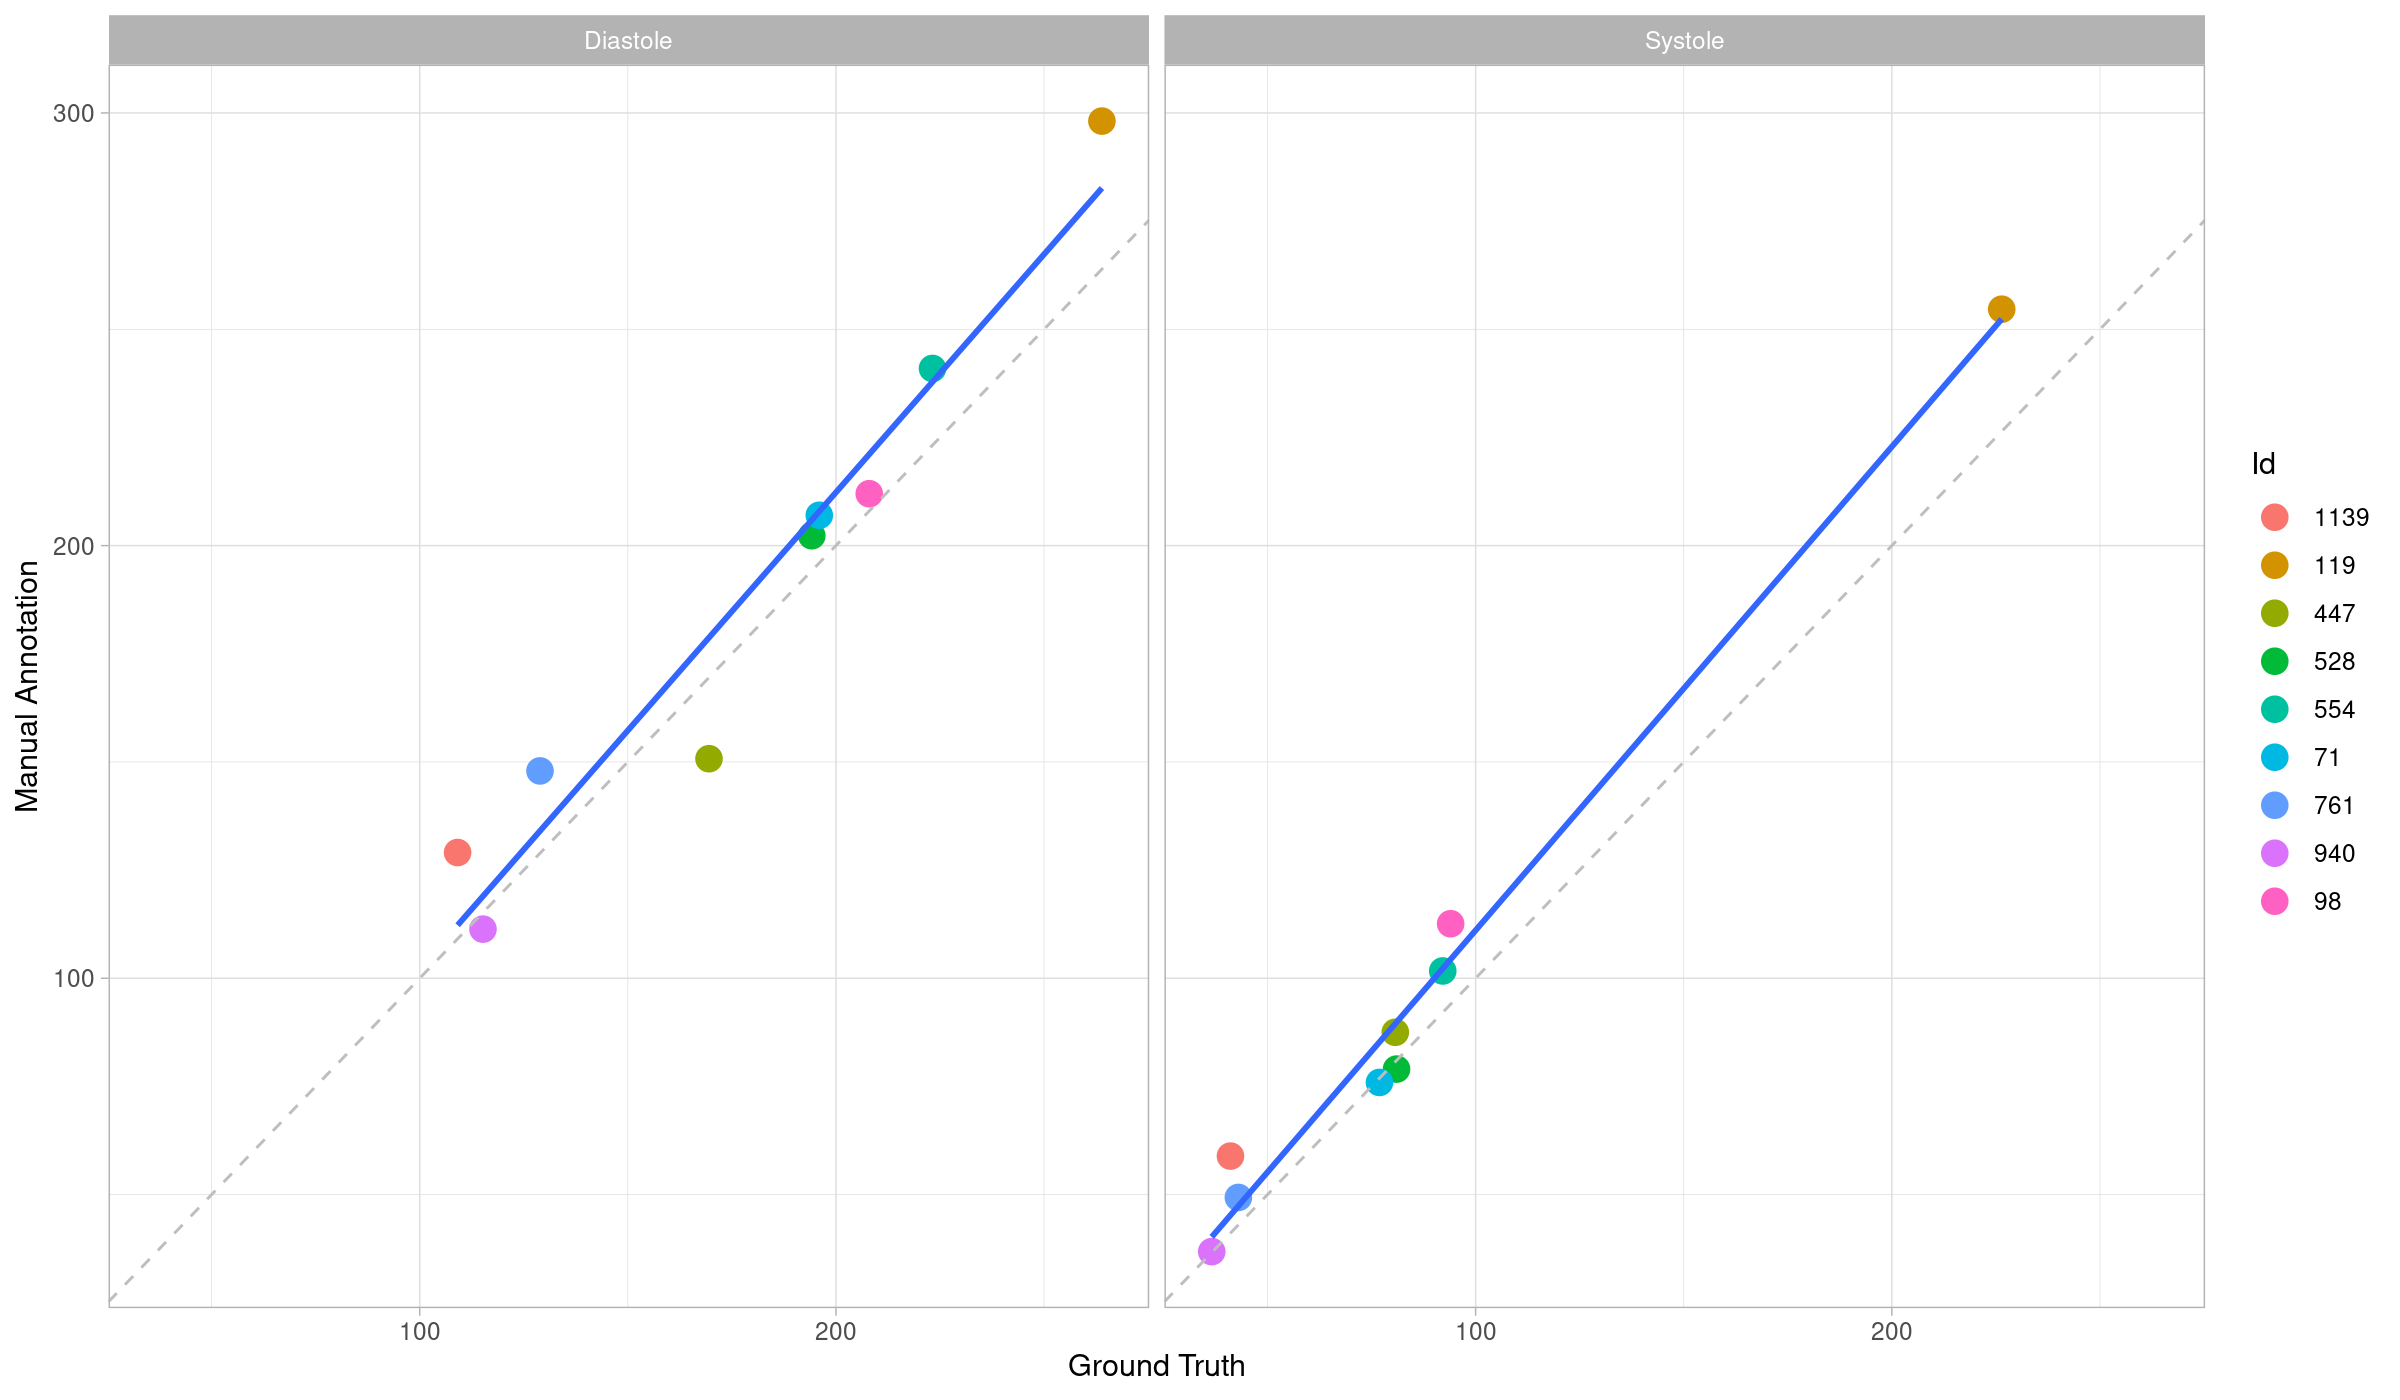

In [8]:
pred_vs_true %>%
    mutate(
        phase=if_else(phase=="dia","Diastole","Systole")
    ) %>%
    ggplot(aes(gt,own)) +
        geom_point(aes(color=Id),size=4) +
        facet_wrap(.~phase) +
        geom_abline(slope = 1, lty=2, color="grey") +
        geom_smooth(method="lm", se=FALSE) +
        xlab("Ground Truth") + ylab("Manual Annotation")
        NULL

In [9]:
ggsave("fig_S2.png", width=10)
ggsave("fig_S2.tiff", width=10)
ggsave("fig_S2.svg", width=10)

Saving 10 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 10 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Saving 10 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'



In [10]:
library(magrittr)


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [11]:
pred_vs_true %$% cor(gt, own)

[1] 0.9882034

In [12]:
lm_dia <- lm(gt ~ own, pred_vs_true[pred_vs_true$phase=="dia",])
summary(lm_dia)


Call:
lm(formula = gt ~ own, data = pred_vs_true[pred_vs_true$phase == 
    "dia", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-18.439  -8.256   1.778   4.021  23.407 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 17.14499   15.88058    1.08    0.316    
own          0.85541    0.08061   10.61 1.44e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.59 on 7 degrees of freedom
Multiple R-squared:  0.9415,	Adjusted R-squared:  0.9331 
F-statistic: 112.6 on 1 and 7 DF,  p-value: 1.445e-05


In [13]:
lm_sys <- lm(gt ~ own, pred_vs_true[pred_vs_true$phase=="sys",])
summary(lm_sys)


Call:
lm(formula = gt ~ own, data = pred_vs_true[pred_vs_true$phase == 
    "sys", ])

Residuals:
     Min       1Q   Median       3Q      Max 
-12.6851  -2.3646   0.5885   2.2756   9.4849 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.86761    4.56894   0.409    0.695    
own          0.88158    0.04046  21.790 1.08e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.382 on 7 degrees of freedom
Multiple R-squared:  0.9855,	Adjusted R-squared:  0.9834 
F-statistic: 474.8 on 1 and 7 DF,  p-value: 1.082e-07


In [14]:
conf_mat <- read_tsv("../../analysis/kaggle/manual/ukbb_vs_manual.tsv") %>%
    separate(image,into=c("Id","frame","slice"),sep="-",remove = F) %>%
    mutate(
        frame=str_replace(frame,"frame",""),
        frame=as.numeric(frame),
        slice=str_replace(slice,"slice",""),
        slice=str_replace(slice,".png",""),
        slice=as.numeric(slice)
    ) %>%
    filter(Id != 98 | frame %in% seq(0,20,4))


── Column specification ────────────────────────────────────────────────────────────────────────────────
cols(
  image = col_character(),
  set = col_double(),
  methodA = col_character(),
  methodB = col_character(),
  bg_bg = col_double(),
  bg_lv = col_double(),
  bg_my = col_double(),
  lv_bg = col_double(),
  lv_lv = col_double(),
  lv_my = col_double(),
  my_bg = col_double(),
  my_lv = col_double(),
  my_my = col_double()
)




In [15]:
ukbb_confidence <- read_tsv("../../analysis/kaggle/confidence_by_patient.tsv")


── Column specification ────────────────────────────────────────────────────────────────────────────────
cols(
  Id = col_character(),
  predicted_LVEDV = col_double(),
  predicted_LVESV = col_double(),
  predicted_LVEF = col_double(),
  true_LVEDV = col_double(),
  true_LVESV = col_double(),
  true_LVEF = col_double(),
  set = col_character(),
  sys_diff = col_double(),
  sys_perc = col_double(),
  dia_diff = col_double(),
  dia_perc = col_double(),
  confidence = col_double()
)




In [16]:
conf_mat <- conf_mat %>%
    mutate(Id=as.character(set)) %>%
    left_join(select(ukbb_confidence, Id, confidence))

Joining, by = "Id"



In [17]:
prepare_confusion_table <- function(data){
   return(data %>% mutate(
            slice=str_replace(image,".*-slice(\\d+).png","\\1") %>% as.numeric,
            frame=str_replace(image,".*-frame(\\d+).*","\\1") %>% as.numeric,
            #total=256*256,
            bg_all=bg_bg+bg_lv+bg_my,
            all_bg=bg_bg+lv_bg+my_bg,
            lv_all=lv_bg+lv_lv+lv_my,
            all_lv=bg_lv+lv_lv+my_lv,
            dice_lv=if_else(lv_all+all_lv==0, 1, 2*lv_lv/(lv_all+all_lv)),
            my_all=my_bg+my_lv+my_my,
            all_my=bg_my+lv_my+my_my,
            dice_my=if_else(my_all+all_my==0, 1, 2*my_my/(my_all+all_my))
        ) %>%
        select(-image)
    ) 
}

In [18]:
conf_mat_full <- prepare_confusion_table(conf_mat)

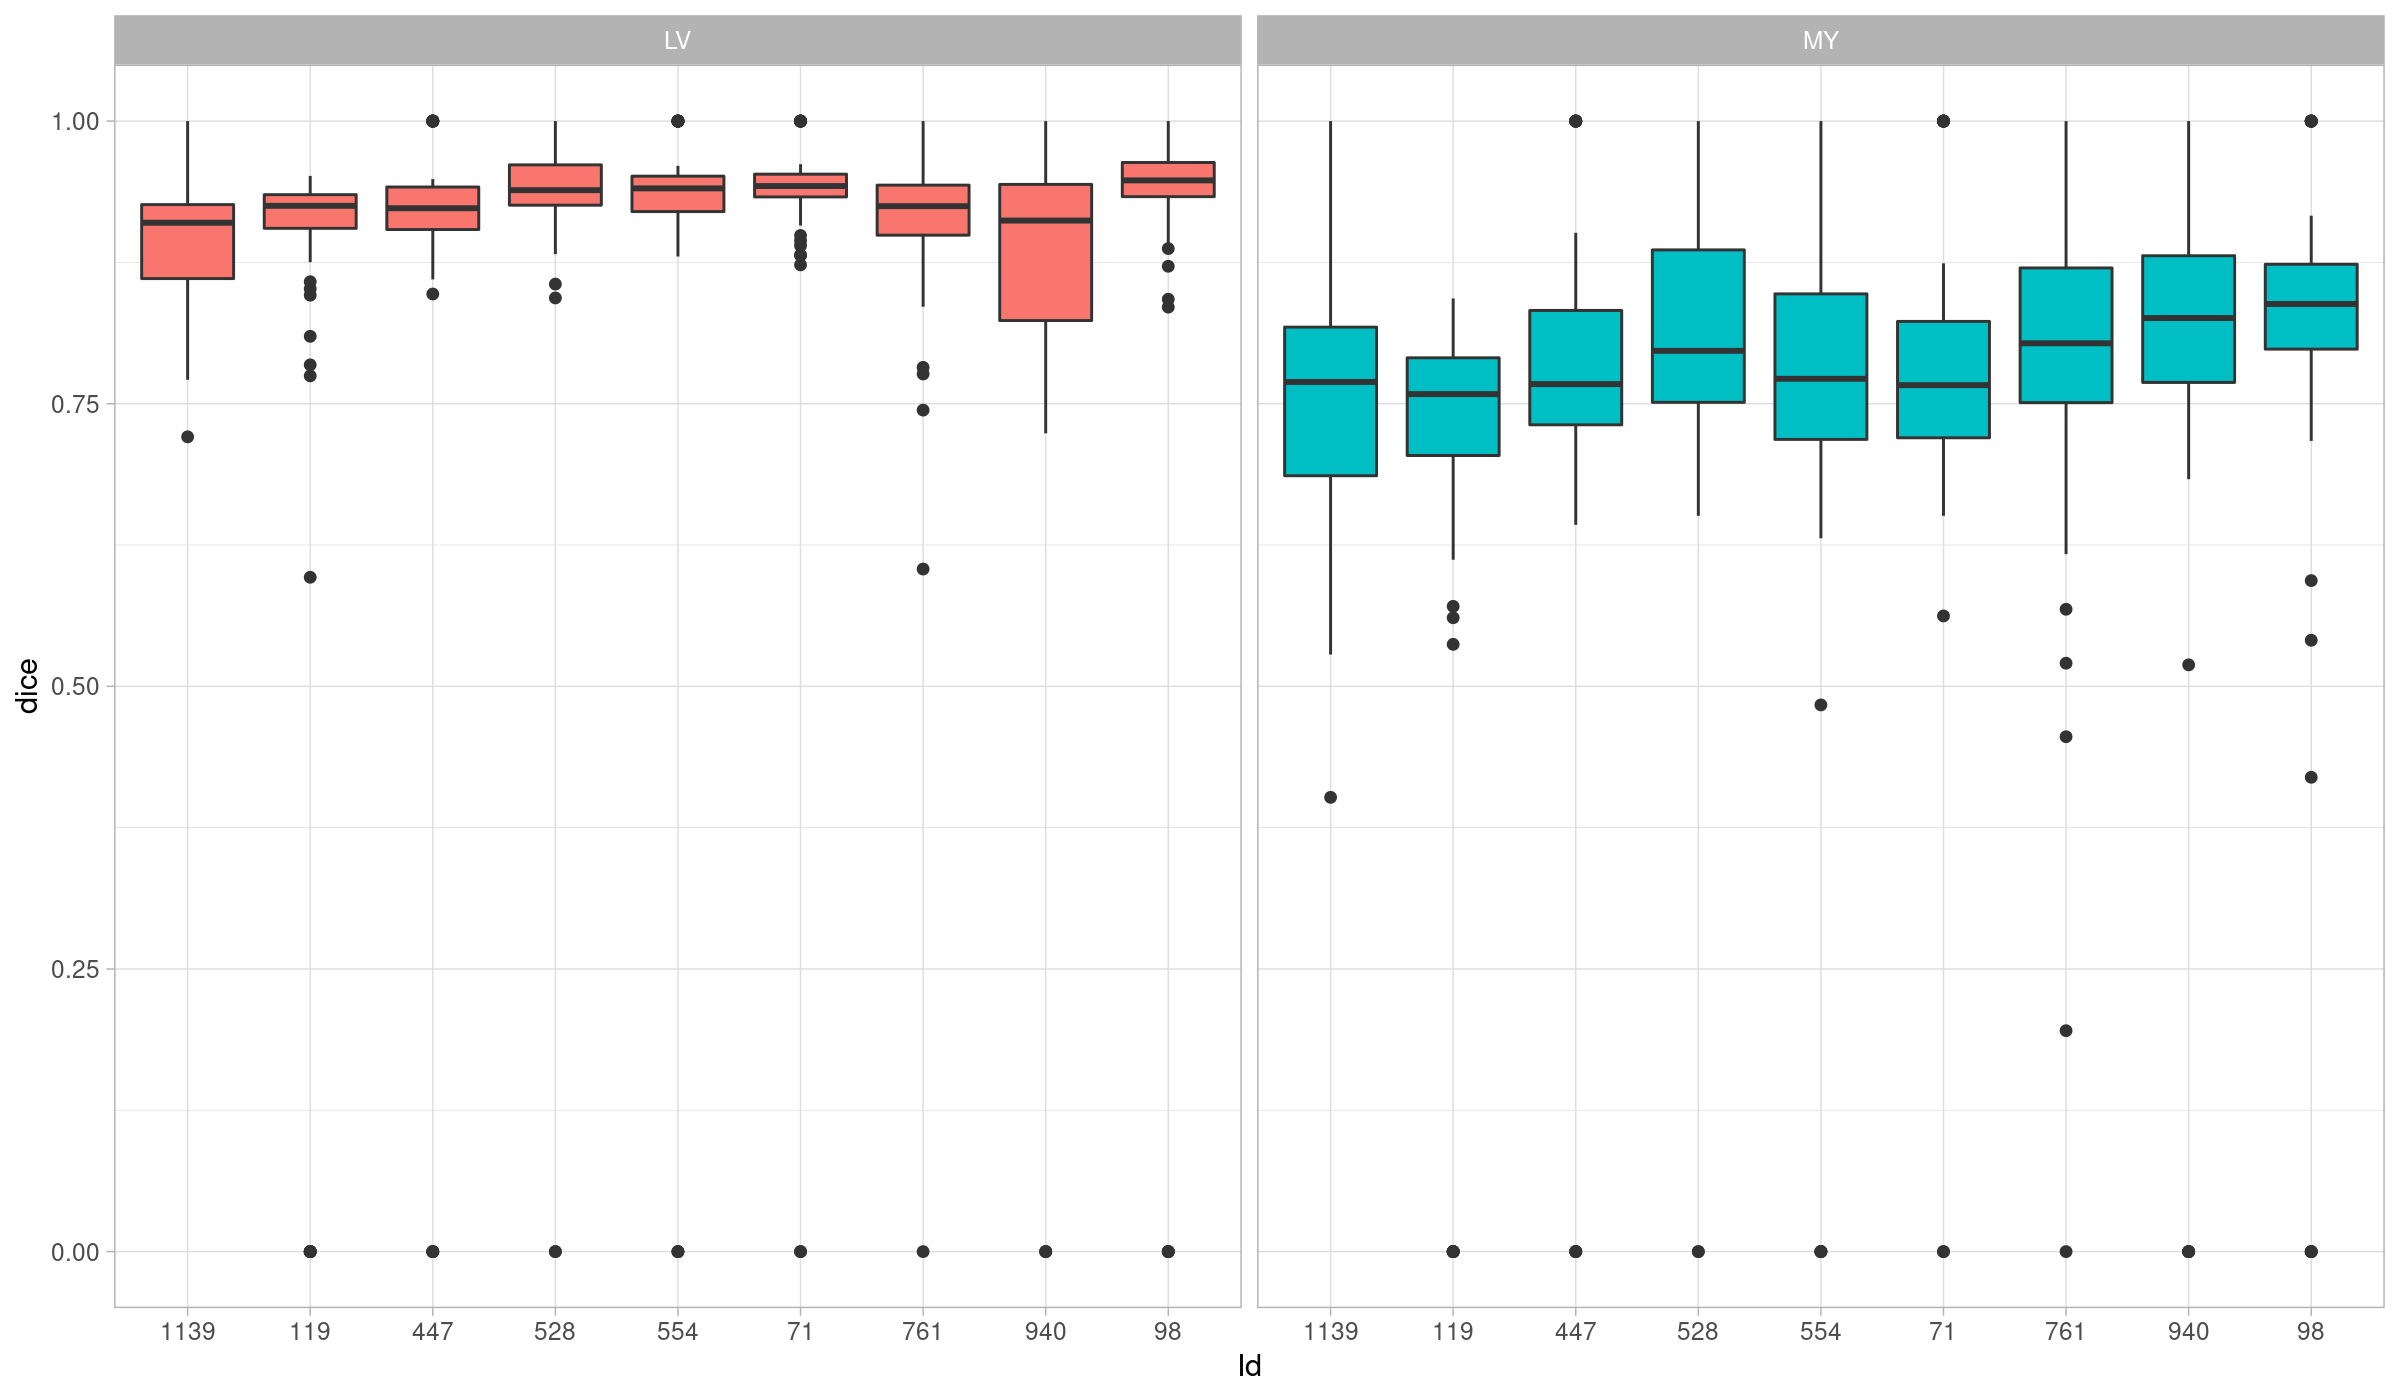

In [19]:
conf_mat_full %>%
    select(Id, contains("dice"), confidence) %>%
    rename(LV=dice_lv, MY=dice_my) %>%
    pivot_longer(names_to="class", values_to="dice", LV:MY) %>%
    ggplot(aes(Id, dice, fill=class)) +
        geom_boxplot()+#, outlier.shape = NA) +
        #geom_jitter(aes(color=class)) +
        facet_wrap(class ~ .) +
        theme(legend.position = "none")

In [20]:
ggsave("fig_S3.png", width=10)
ggsave("fig_S3.tiff", width=10)
ggsave("fig_S3.svg", width=10)

Saving 10 x 6.67 in image

Saving 10 x 6.67 in image

Saving 10 x 6.67 in image



In [21]:
conf_mat_full %>% summarize(median(dice_lv), median(dice_my))

median(dice_lv),median(dice_my)
<dbl>,<dbl>
0.9328518,0.7864628


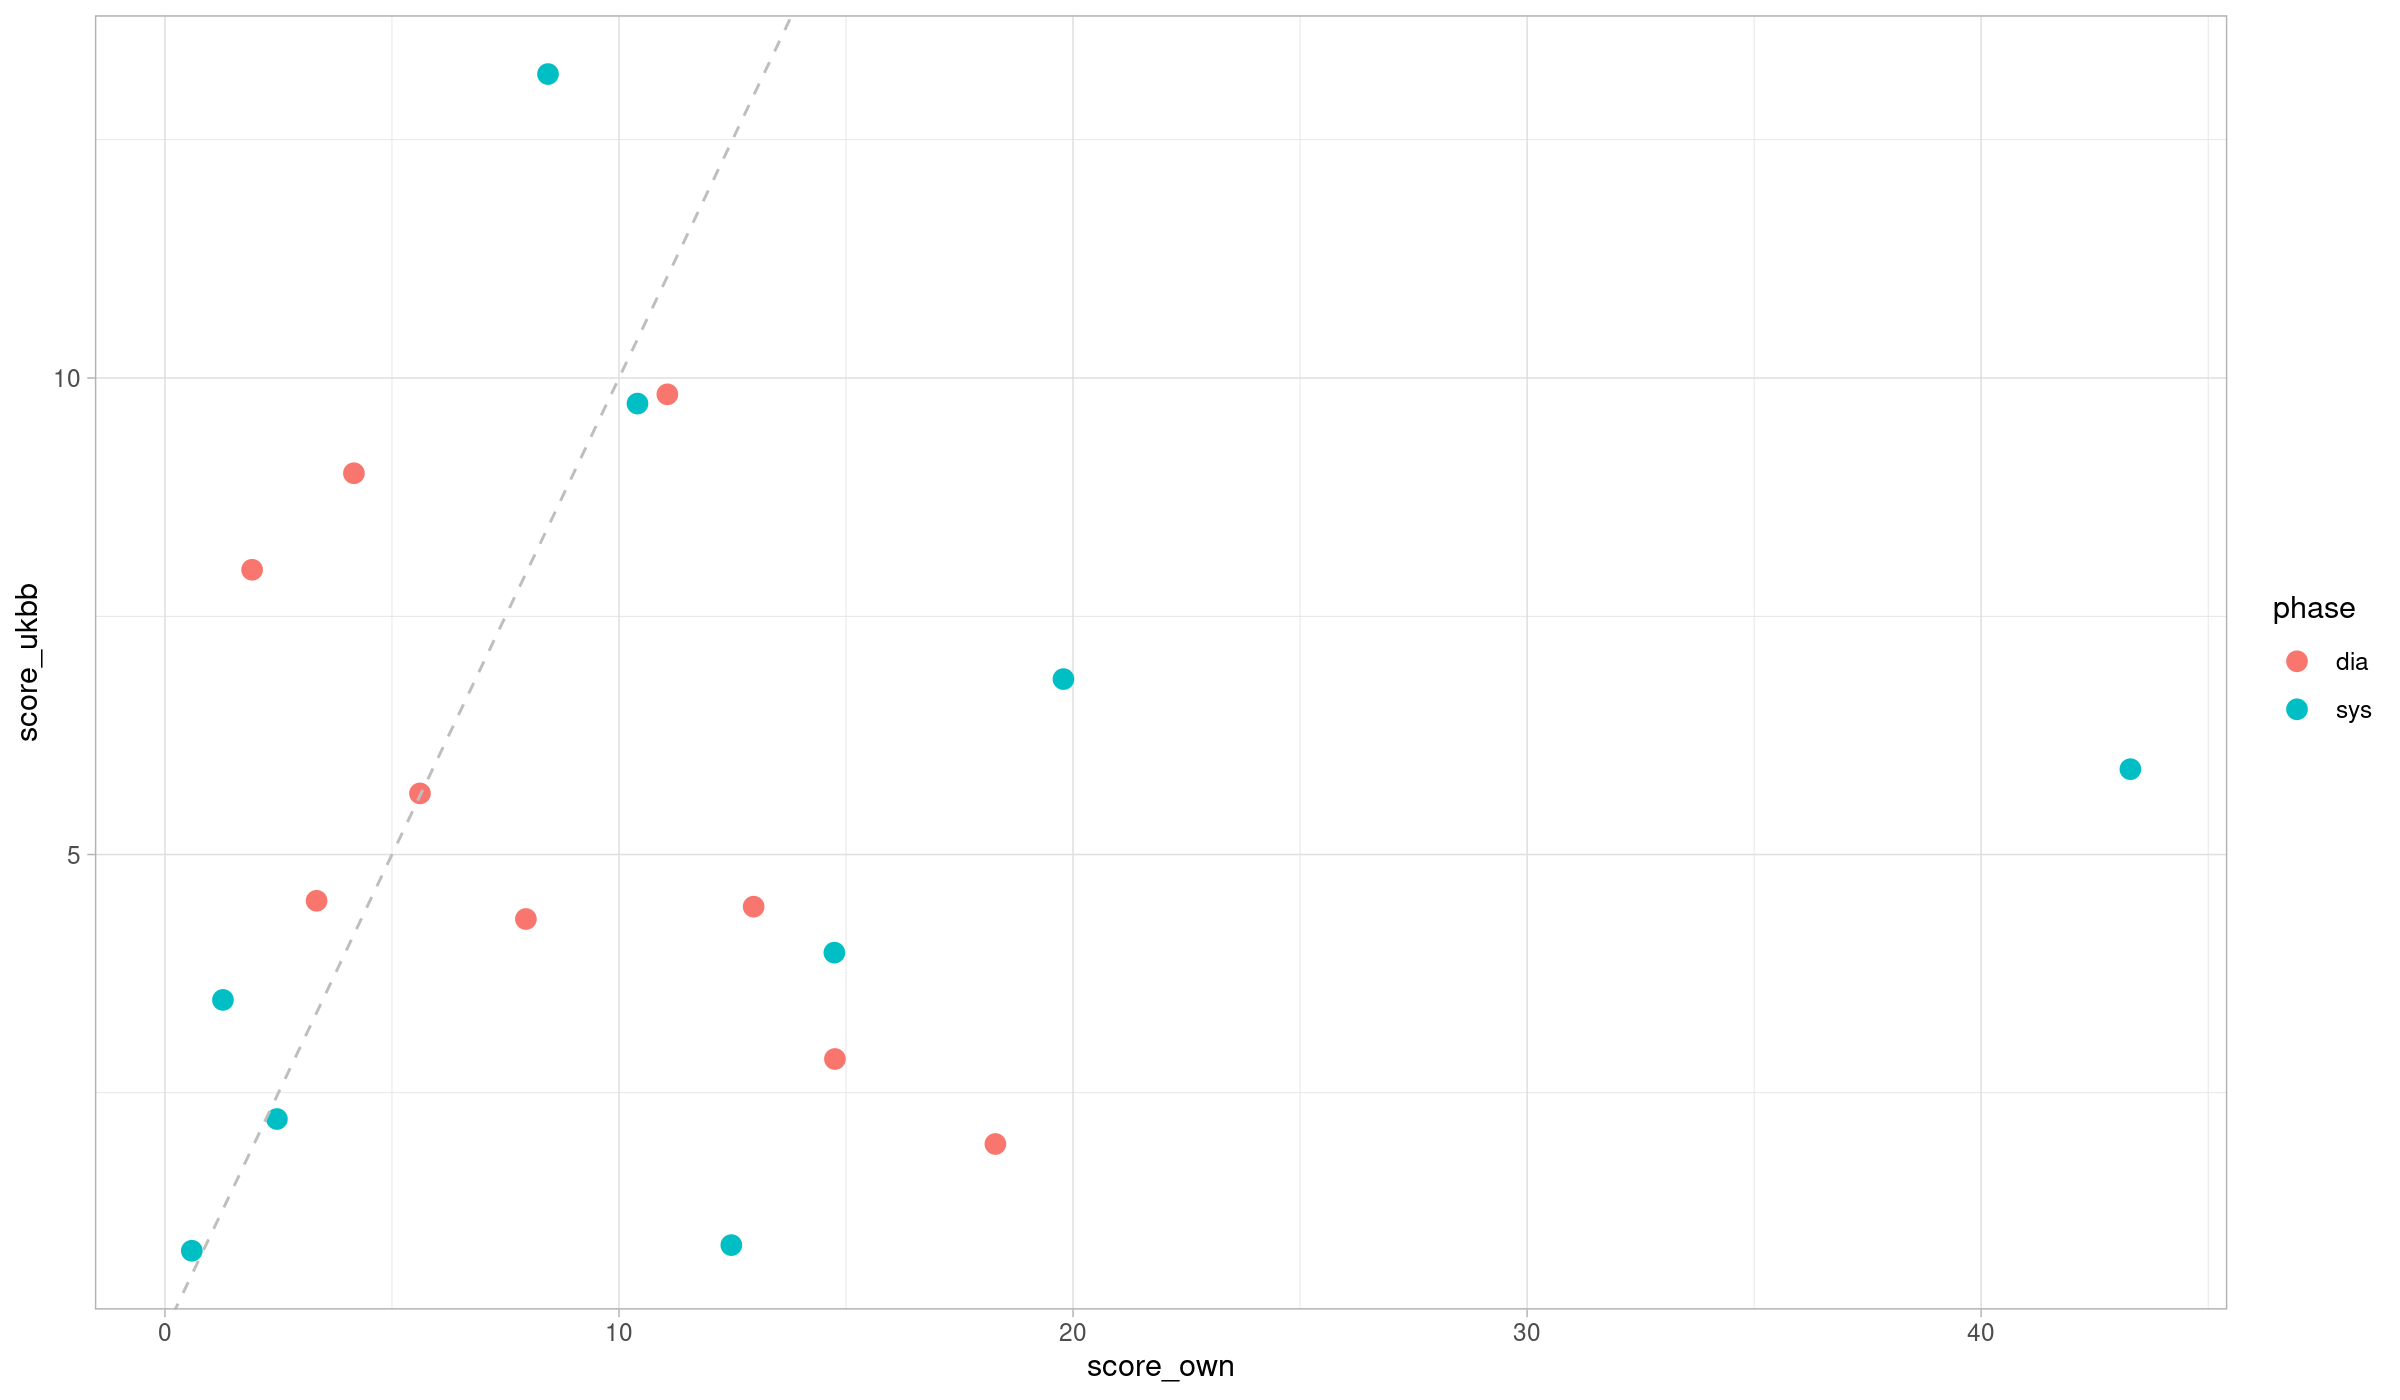

In [22]:
pred_vs_true %>% mutate(
    score_ukbb=100*abs(ukbb-gt)/gt,
    score_own=100*abs(own-gt)/gt
) %>% ggplot(aes(score_own,score_ukbb,color=phase)) +
    geom_point(size=3) +
    geom_abline(slope=1, lty=2, color="grey")

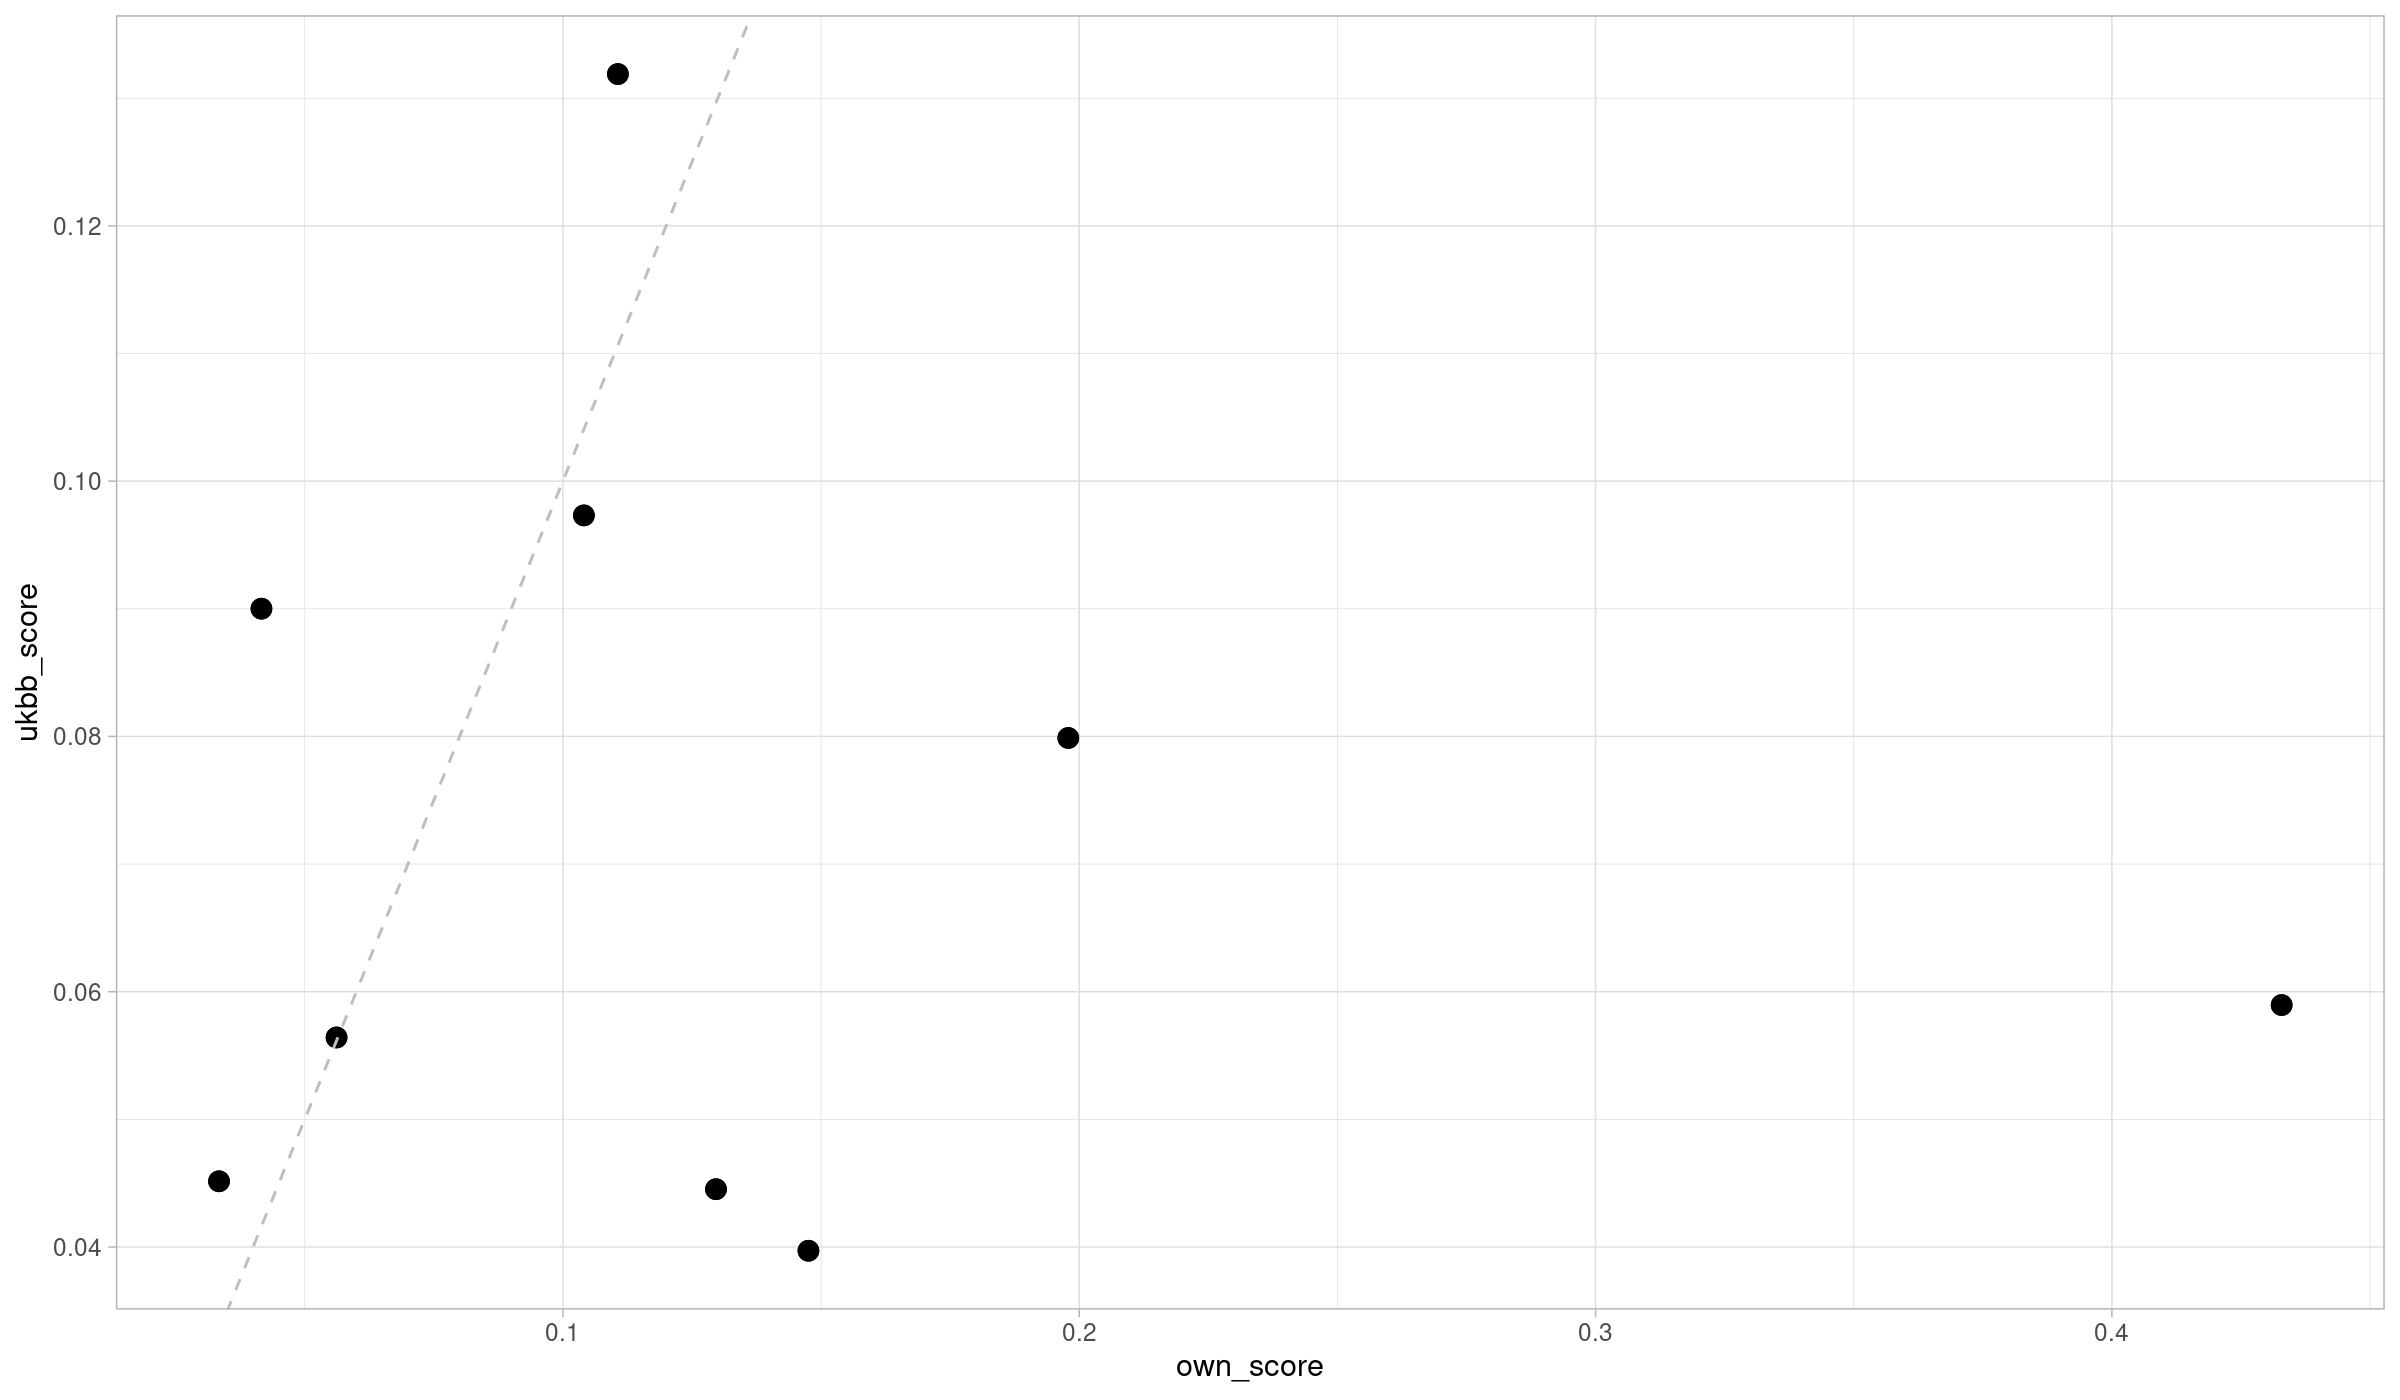

In [23]:
pred_vs_true %>%
    group_by(Id) %>%
    mutate(
        own_score=max(abs(own-gt)/gt),
        ukbb_score=max(abs(ukbb-gt)/gt)
    ) %>%
    ggplot(aes(own_score,ukbb_score)) +
        geom_point(size=3) +
        geom_abline(slope=1,lty=2,color="gray")

Warning message:
“Ignoring unknown aesthetics: class”
`geom_smooth()` using formula 'y ~ x'



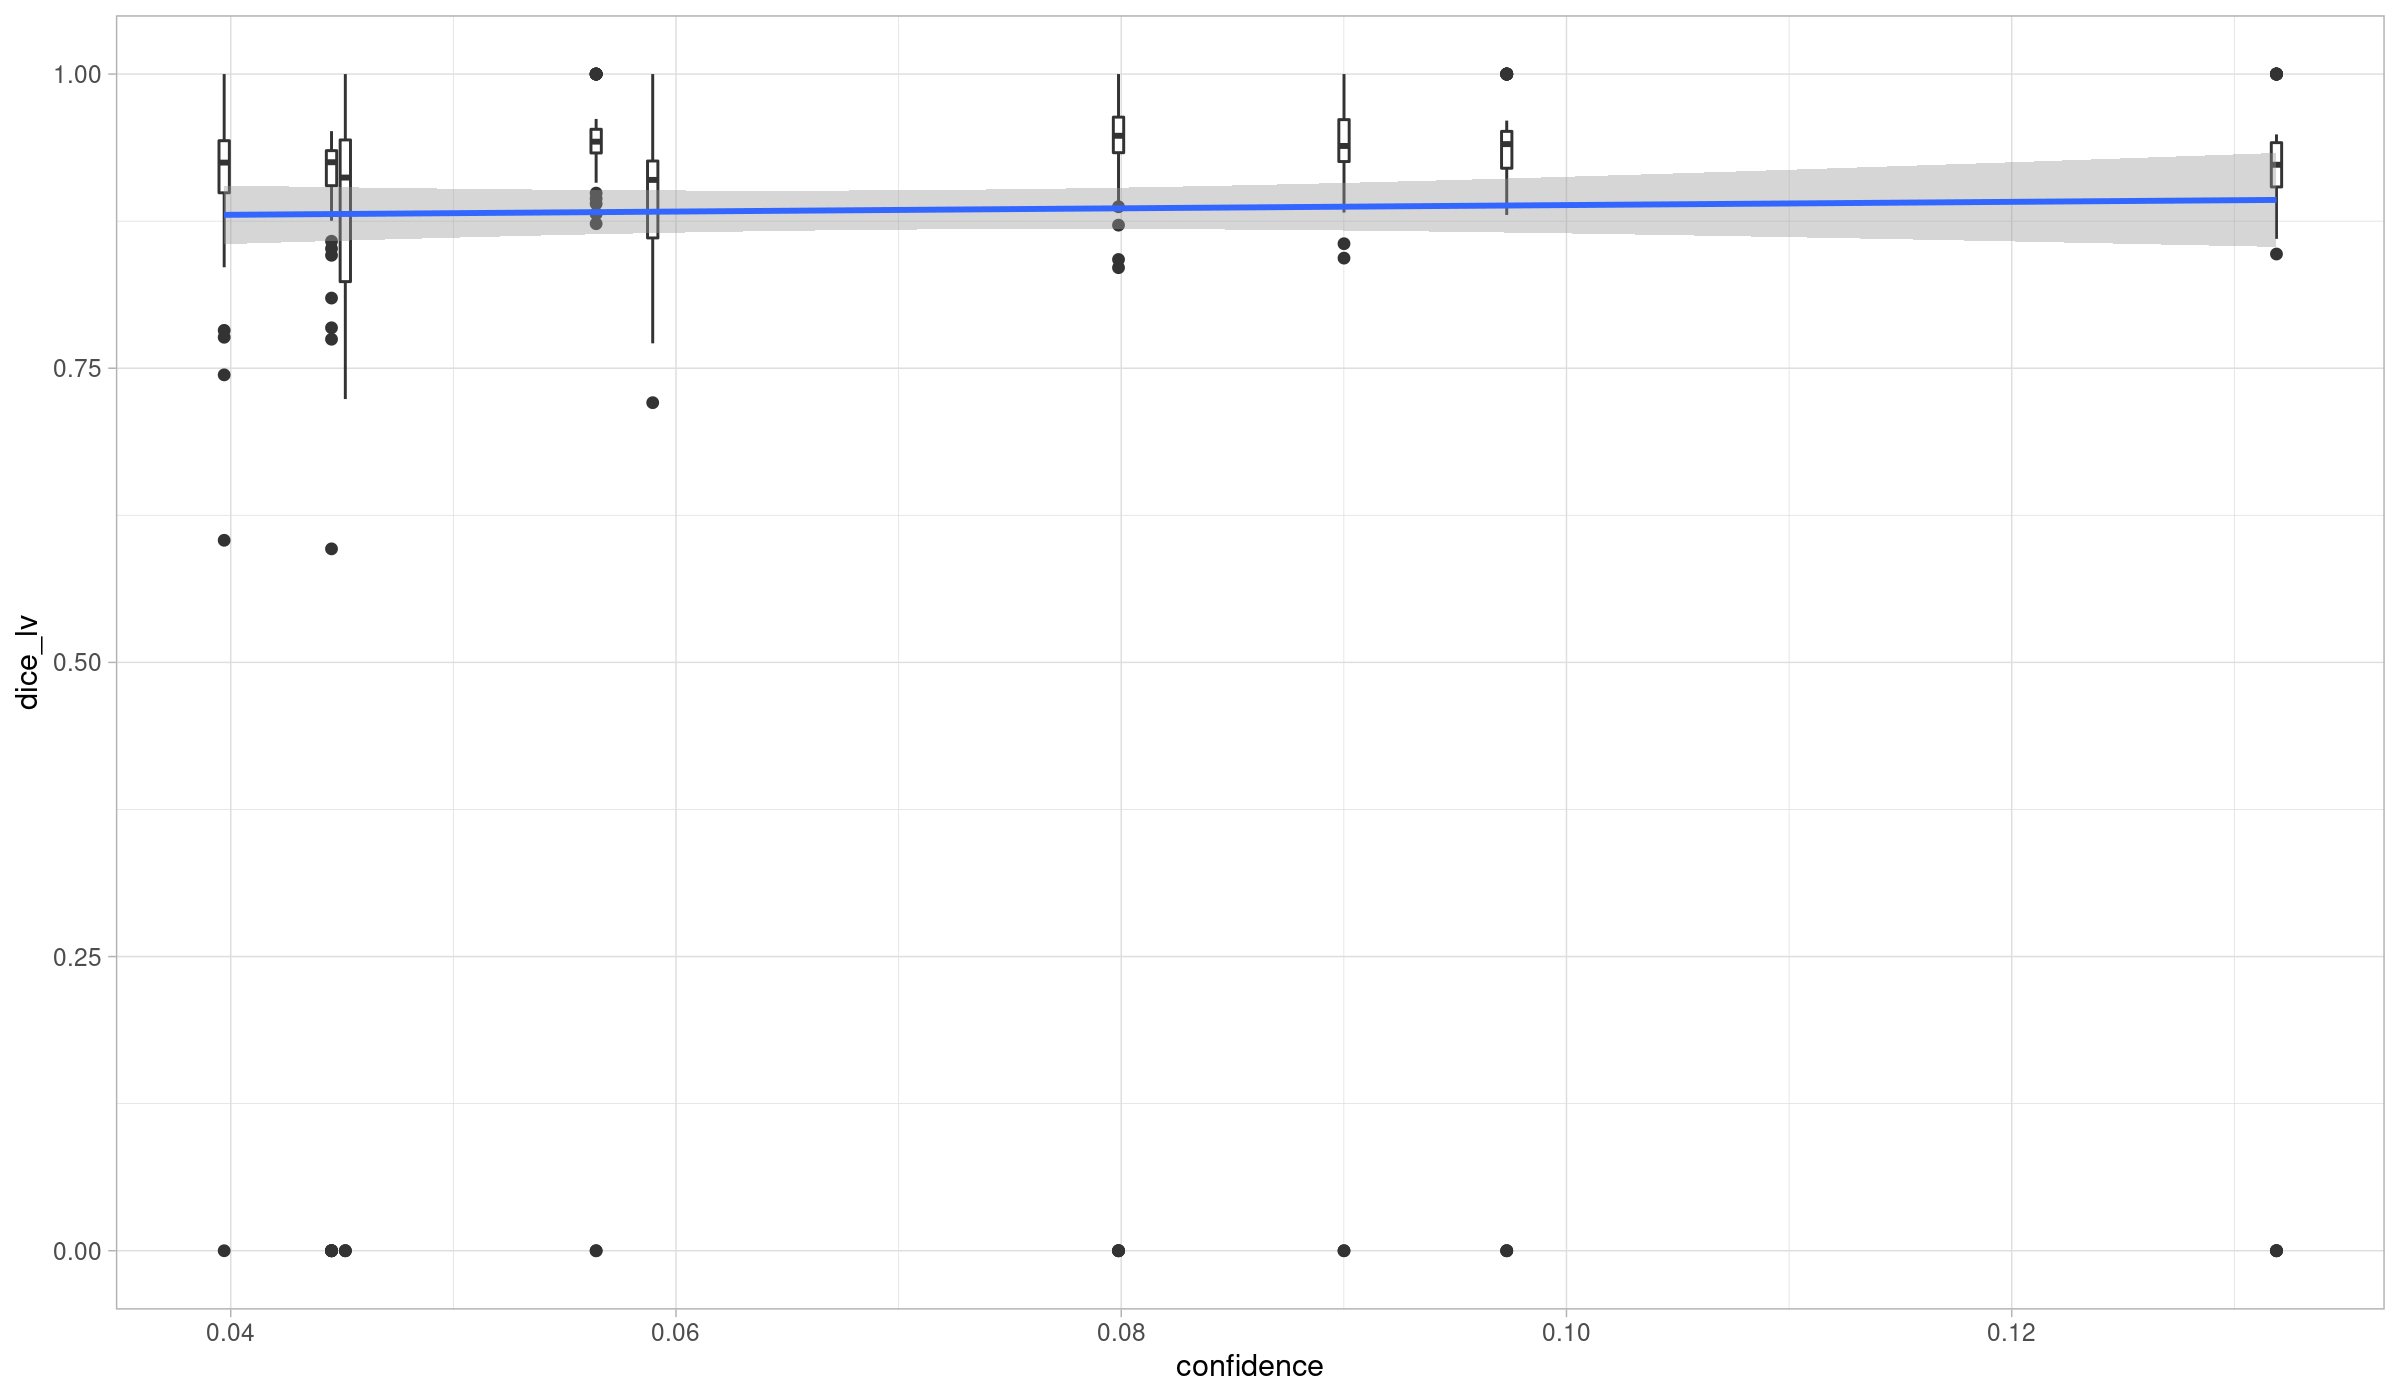

In [24]:
conf_mat_full %>% select(Id, contains("dice"), confidence) %>%
    ggplot(aes(confidence, dice_lv)) +
        geom_boxplot(aes(class=Id)) +
        geom_smooth(method="lm")

In [25]:
conf_mat_full %>% dim

[1] 552  24


── Column specification ────────────────────────────────────────────────────────────────────────────────
cols(
  image = col_character(),
  set = col_double(),
  methodA = col_character(),
  methodB = col_character(),
  bg_bg = col_double(),
  bg_lv = col_double(),
  bg_my = col_double(),
  lv_bg = col_double(),
  lv_lv = col_double(),
  lv_my = col_double(),
  my_bg = col_double(),
  my_lv = col_double(),
  my_my = col_double()
)




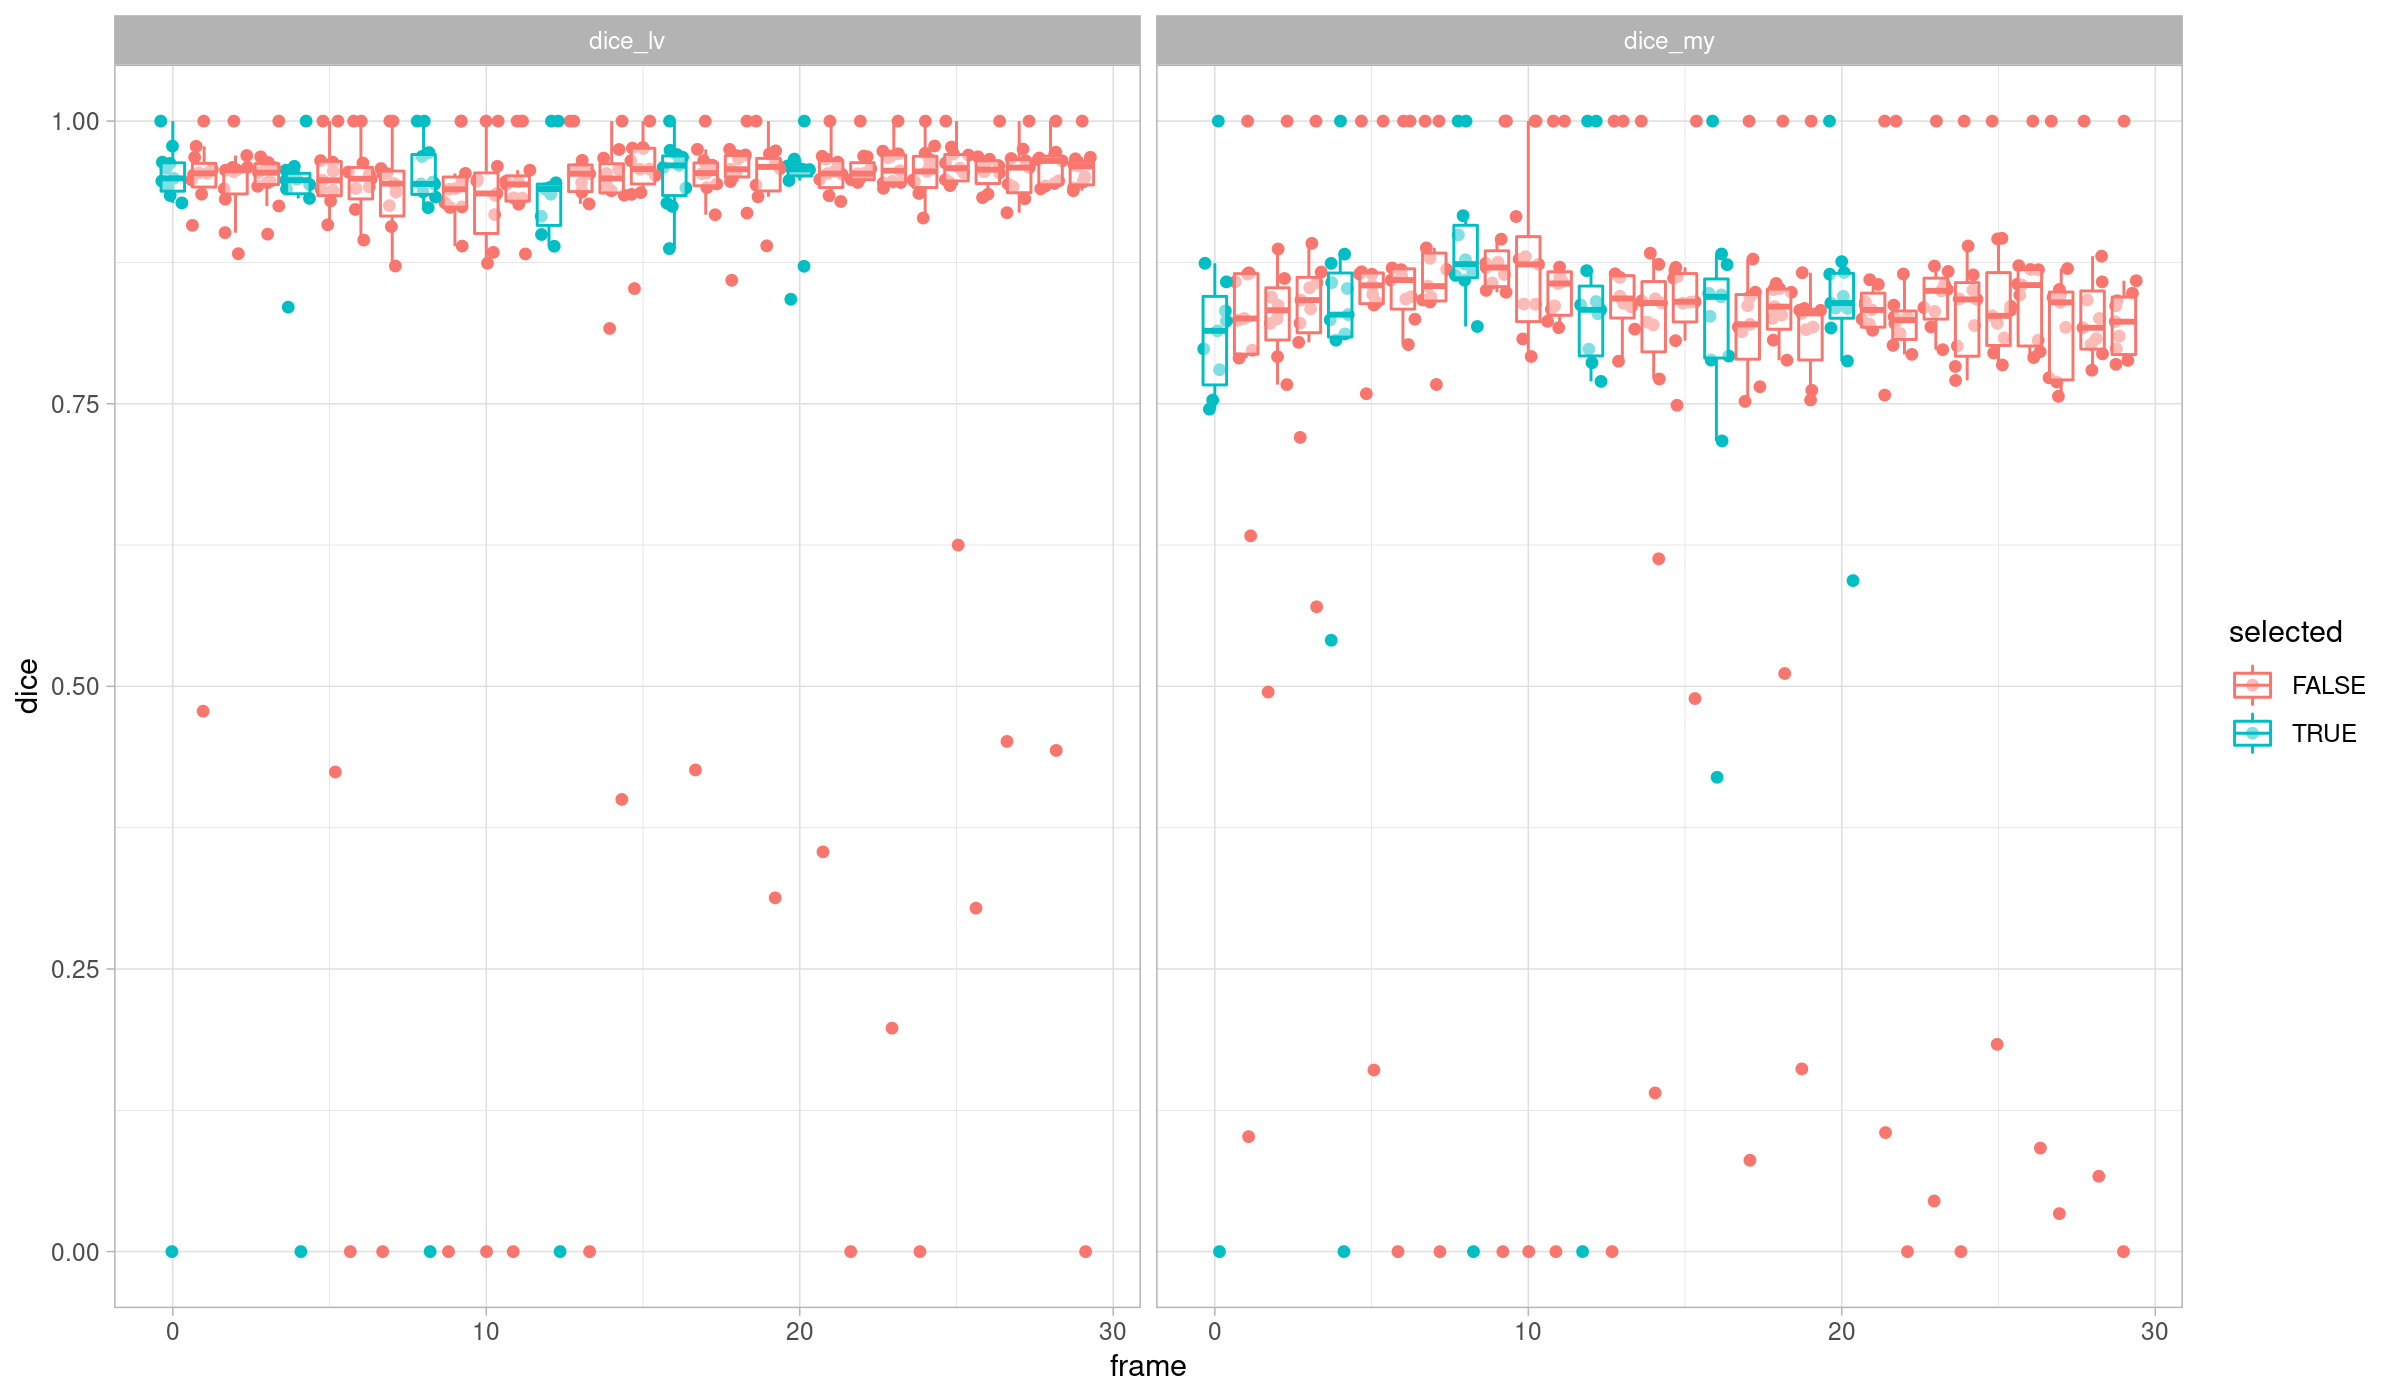

In [26]:
prepare_confusion_table(read_tsv("../../analysis/kaggle/manual/ukbb_vs_manual.tsv")) %>%
    filter(set==98) %>%
    mutate(
        selected=frame %in% seq(0,20,4)
    ) %>%
    pivot_longer(names_to="score",values_to="dice",contains("dice")) %>%
    ggplot(aes(frame,dice,color=selected)) +
        geom_jitter() +
        geom_boxplot(aes(group=frame),alpha=.5,outlier.shape = NA) +
        facet_grid(. ~ score)